根據COVID-19數據資料，分析台灣疫情相關數據

資料來源-疾病管制署資料開放平台

https://data.cdc.gov.tw/dataset/aagsdctable-day-19cov/resource/a65c7cb5-8a3c-4859-a27a-9019f65dd66e

# 資料導入

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# original_url = 'https://data.cdc.gov.tw/download?resourceid=a65c7cb5-8a3c-4859-a27a-9019f65dd66e&dataurl=https://od.cdc.gov.tw/eic/Day_Confirmation_Age_County_Gender_19CoV.csv'

In [3]:
# 因應github檔案限制25MB，刪除不用欄位並進行壓縮
"""
f=pd.read_csv("Day_Confirmation_Age_County_Gender_19CoV.csv")
keep_col = ['個案研判日','縣市','性別','年齡層', '確定病例數']
new_f = f[keep_col]
new_f.to_csv('del_unused_columns.gz', compression='gzip', index=False)
"""

In [4]:
# 資料日期 2023/2/1
address = 'del_unused_columns.gz'

In [25]:
df = pd.read_csv(address)
df.tail()

,個案研判日,縣市,性別,年齡層,確定病例數
1976384,2023/02/01,澎湖縣,女,70+,1
1976385,2023/02/01,澎湖縣,男,20-24,1
1976386,2023/02/01,澎湖縣,男,25-29,2
1976387,2023/02/01,澎湖縣,男,50-54,1
1976388,2023/02/01,澎湖縣,男,70+,1


In [6]:
df.shape

(1976389, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1976389 entries, 0 to 1976388
Data columns (total 5 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   個案研判日   object
 1   縣市      object
 2   性別      object
 3   年齡層     object
 4   確定病例數   int64 
dtypes: int64(1), object(4)
memory usage: 75.4+ MB


In [8]:
df.describe(include='all')

,個案研判日,縣市,性別,年齡層,確定病例數
count,1976389,1976389,1976389,1976389,1.976389e+06
unique,937,23,4,19,NaN
top,2022/06/06,台中市,女,70+,NaN
freq,10210,219248,1002018,138264,NaN
mean,NaN,NaN,NaN,NaN,4.855557e+00
std,NaN,NaN,NaN,NaN,7.545128e+00
min,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,1.000000e+00
50%,NaN,NaN,NaN,NaN,2.000000e+00
75%,NaN,NaN,NaN,NaN,5.000000e+00


# 資料分析

## 最新資料日期

In [9]:
df['個案研判日'].max()

'2023/02/01'

## 累計確定病例數 (台灣)

In [10]:
df['確定病例數'].sum()

9596469

## 病例數增加趨勢圖

In [11]:
# https://stackoverflow.com/questions/63218645/lowering-the-x-axis-value-density-for-dates-on-a-seaborn-line-plot

In [12]:
df_group = df.groupby('個案研判日')['確定病例數'].agg(sum).reset_index()
df_group.tail()

,個案研判日,確定病例數
932,2023/01/28,27348
933,2023/01/29,22286
934,2023/01/30,32265
935,2023/01/31,31798
936,2023/02/01,27079


In [13]:
df_group['個案研判日'] = pd.to_datetime(df_group['個案研判日'], format = '%Y/%m/%d')

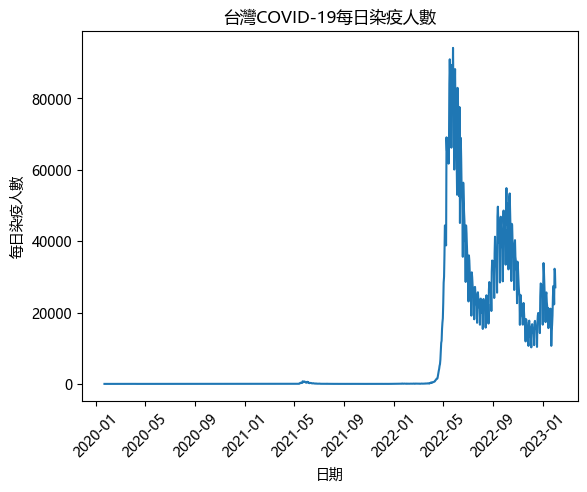

In [14]:
sns.lineplot(data=df_group, x='個案研判日', y='確定病例數')
plt.xlabel("日期")
plt.xticks(rotation=45)
plt.ylabel("每日染疫人數")
plt.title("台灣COVID-19每日染疫人數")
plt.rcParams['font.sans-serif']=['Microsoft Yahei']
plt.show()

## 依縣市，將病例數標計在地圖上

In [15]:
import geopandas as gpd

C:\Users\napol\AppData\Local\Temp\ipykernel_16076\3841419929.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [16]:
town_shp = gpd.read_file('COUNTY_MOI_1090820.shp', encoding='utf-8')
town_shp.head()

,COUNTYID,COUNTYCODE,COUNTYNAME,COUNTYENG,geometry
0,Z,09007,連江縣,Lienchiang County,"MULTIPOLYGON (((119.96445 25.94552, 119.96427 ..."
1,G,10002,宜蘭縣,Yilan County,"MULTIPOLYGON (((121.95971 24.84494, 121.96064 ..."
2,N,10007,彰化縣,Changhua County,"POLYGON ((120.45655 24.20719, 120.48589 24.197..."
3,M,10008,南投縣,Nantou County,"POLYGON ((121.27086 24.23661, 121.27108 24.236..."
4,P,10009,雲林縣,Yunlin County,"MULTIPOLYGON (((120.08108 23.52412, 120.08161 ..."


In [17]:
df_county = df.groupby('縣市')['確定病例數'].agg(sum).reset_index()
df_county['縣市'] = df_county['縣市'].str.replace('台', '臺')

In [18]:
county_merge = town_shp.merge(df_county, left_on=('COUNTYNAME'), right_on=('縣市'))
county_merge.head()

,COUNTYID,COUNTYCODE,COUNTYNAME,COUNTYENG,geometry,縣市,確定病例數
0,Z,09007,連江縣,Lienchiang County,"MULTIPOLYGON (((119.96445 25.94552, 119.96427 ...",連江縣,3893
1,G,10002,宜蘭縣,Yilan County,"MULTIPOLYGON (((121.95971 24.84494, 121.96064 ...",宜蘭縣,184838
2,N,10007,彰化縣,Changhua County,"POLYGON ((120.45655 24.20719, 120.48589 24.197...",彰化縣,452703
3,M,10008,南投縣,Nantou County,"POLYGON ((121.27086 24.23661, 121.27108 24.236...",南投縣,155397
4,P,10009,雲林縣,Yunlin County,"MULTIPOLYGON (((120.08108 23.52412, 120.08161 ...",雲林縣,196659


Populating the interactive namespace from numpy and matplotlib


D:\ANACONDA\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Text(0.5, 1.0, '台灣各縣市COVID-19確診病例人數 (單位-人)')

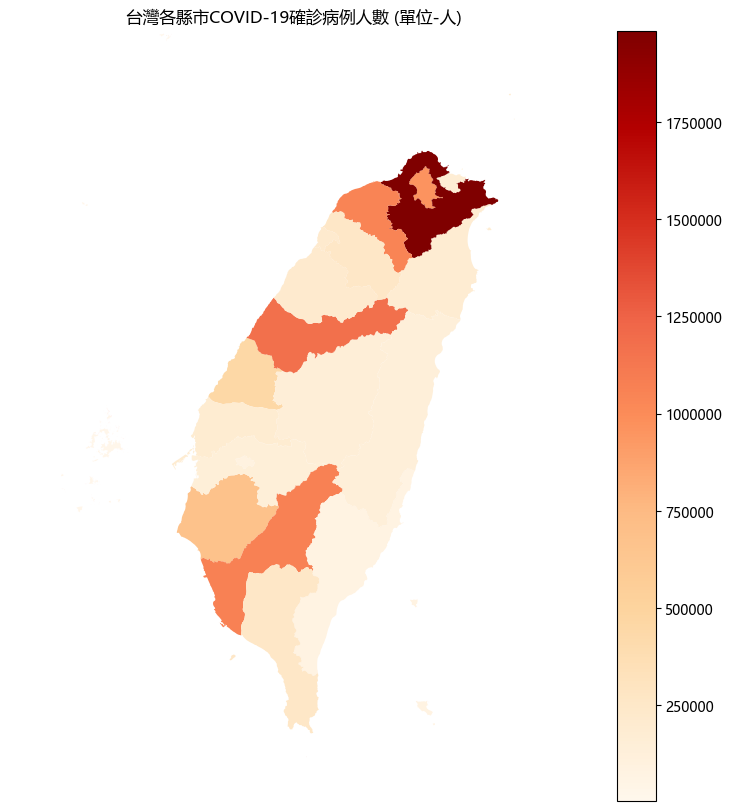

In [19]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
import pysal
ax = county_merge.plot(column='確定病例數', k=10, cmap='OrRd', legend=True, legend_kwds={'format':"%d"})
ax.set_xlim(119, 122.5)
ax.set_ylim(21.5, 26)
ax.set_axis_off()
ax.set_title('台灣各縣市COVID-19確診病例人數 (單位-人)')

In [20]:
# 參考資料 https://viml.nchc.org.tw/archive_blog_687/

## COVID-19確診者性別統計

In [21]:
df_group2 = df.groupby('性別')['確定病例數'].agg(sum).reset_index()
df_group2

,性別,確定病例數
0,女,5119461
1,性別不詳,1698
2,男,4475122
3,第三性,188


Text(0.5, 1.0, 'COVID-19確診者性別統計')

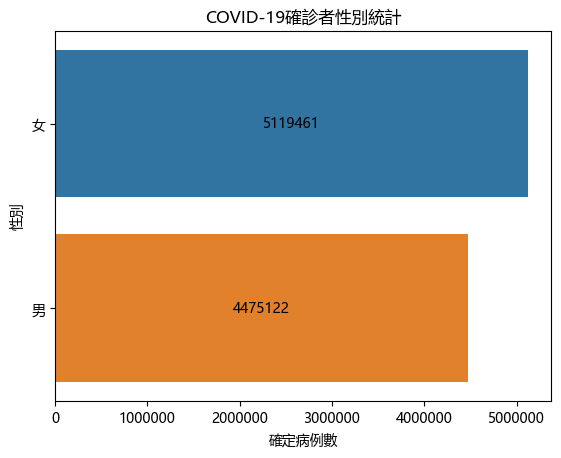

In [22]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
g = sns.barplot(data=df_group2.loc[[0,2],:], x='確定病例數', y='性別')
plt.ticklabel_format(style='plain', axis='x')
g.bar_label(g.containers[0], fmt='%d', label_type='center')
g.set_title('COVID-19確診者性別統計')

## 確診年齡層統計

In [23]:
df['年齡層'] = pd.Categorical(df['年齡層'], ['0', '1', '2', '3', '4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70+'])
df_group3 = df.groupby('年齡層')['確定病例數'].agg(sum).reset_index()
df_group3

,年齡層,確定病例數
0,0,58310
1,1,83817
2,2,86007
3,3,87966
4,4,94694
5,5-9,554533
6,10-14,505238
7,15-19,530802
8,20-24,706090
9,25-29,869724


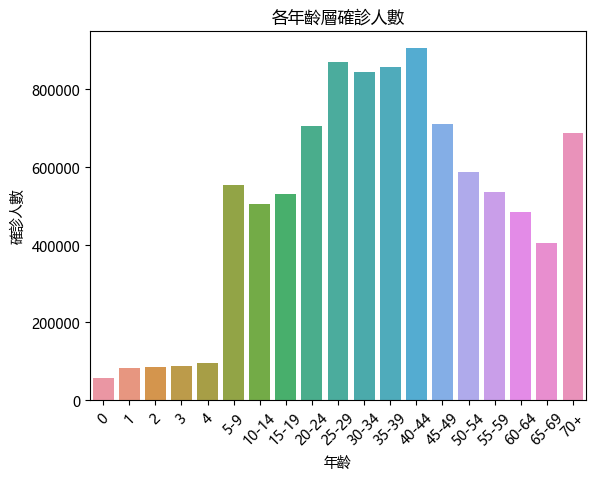

In [24]:
g = sns.barplot(data=df_group3, x='年齡層', y='確定病例數')
plt.xticks(rotation=45)
plt.title('各年齡層確診人數')
plt.xlabel("年齡")
plt.ylabel("確診人數")
plt.show()